In [76]:
def train_test_split(X, y, test_p=0.25, random_state=42):
    ids = np.unique(X.index.values)
    test_size = math.floor(test_p * len(ids))
    test_index = np.random.choice(ids, size=test_size)
    X_train = X[~X.index.isin(test_index)]
    X_test = X[X.index.isin(test_index)]
    y_train = y[~y.index.isin(test_index)]
    y_test = y[y.index.isin(test_index)]
    return X_train, X_test, y_train, y_test

In [322]:
def feature_selection(X_train, y_train, model, variance_threshold=0, step=0.05, num_features=100, verbose=0, n_jobs=10):
    n = len(y_train)
    vals, counts = np.unique(y_train, return_counts=True)
    k = min(counts)
    # Apply variance threshold on features
    # TODO: note that this is probably removing dummy variables with low variance; only matters in multi-drug case
    variance_selector = VarianceThreshold(threshold=variance_threshold)
    variance_selector.fit(X_train)
    var_selected_features = X_train.columns[variance_selector.get_support()]
    X_train_selected = X_train.loc[:, var_selected_features]

    # Recursive feature elimination with cross validation
    selector = RFECV(model, min_features_to_select=num_features, step=step, verbose=verbose, n_jobs=n_jobs, cv=k)
    # TODO: figure out way to output scores of intermediate selectors
    selector.fit(X_train_selected, y_train)
    selected_features = X_train_selected.columns[selector.get_support()]
    return selector, selected_features, var_selected_features

In [78]:
def test_model(X_test, y_test, model):
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return y_pred, score

## Imports and data

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
discretize = 1

In [214]:
expression_df = pd.read_csv('../data/processed/expression_tpm_log.tsv', sep='\t', index_col=0)

In [215]:
expression_df = expression_df.set_index('pog_id')

In [216]:
drugs_df = pd.read_csv('../data/processed/drugs_prognosis.tsv', sep='\t', index_col=0)

In [217]:
drugs_selected_df = drugs_df[['pog_id', 'response', 'prognosis', 'drug_name', 'cancer_cohort']]

# # Prepare features and labels
# ## Join drugs and expression tables

drugs_expression_df = drugs_selected_df.join(expression_df, on='pog_id', how='inner')
drugs_expression_df = drugs_expression_df.set_index('pog_id')
# RESPONSE OR PROGNOSIS?
drugs_expression_df = drugs_expression_df.loc[:, np.append(['response', 'drug_name', 'cancer_cohort'], expression_df.columns.values)]
drugs_expression_df = drugs_expression_df.drop_duplicates()

# cancer_types = np.append(np.unique(drugs_expression_df['cancer_cohort']), 'All')
# drug_names = np.append(np.unique(drugs_expression_df['drug_name']), 'All')

X_master = drugs_expression_df.loc[:, expression_df.columns.values]
# X_master = pd.get_dummies(X_master, columns=['drug_name'])
y_master = drugs_expression_df.loc[:, 'response']

In [437]:
# X = X_master[(drugs_expression_df['cancer_cohort'] == 'BRCA') & (drugs_expression_df['drug_name'] == 'ERIBULIN')]
# y = y_master[(drugs_expression_df['cancer_cohort'] == 'BRCA') & (drugs_expression_df['drug_name'] == 'ERIBULIN')]
X = X_master[drugs_expression_df['drug_name'] == 'GEMCITABINE']
y = y_master[drugs_expression_df['drug_name'] == 'GEMCITABINE']

In [512]:
drugs_df

,pog_id,drug_name,start_date,end_date,days_on_tx,treatment_number,biopsy_date,before_biop,cancer_cohort,cancer_type,...,total_brachy_dose,total_radio_dose,class_1,class_2,pathway_class,days_on_tx_since_biopsy,response,days_on_tx_since_biopsy_std,days_on_tx_since_biopsy_mean,prognosis
2,POG122,IRINOTECAN,2016-03-30,2016-07-20,112,5,2014-09-12,f,COLO,Colorectal Adenocarcinoma,...,0,2000,topoisomerase I inhibitor,DNA synthesis inhibitor,DNA synthesis,112,112,203.928693,186.488372,726
4,POG175,GEMCITABINE,2015-02-23,2015-03-23,28,3,2015-02-04,f,BRCA,Breast Invasive Ductal Carcinoma,...,0,5040,DNA synthesis inhibitor,antimetabolite,DNA synthesis,28,28,102.607759,100.456522,66
6,POG804,GEMCITABINE,2016-04-06,2017-04-18,377,1,2017-04-03,t,BRCA,Breast Invasive Ductal Carcinoma,...,0,6000,DNA synthesis inhibitor,antimetabolite,DNA synthesis,15,15,102.607759,100.456522,129
9,POG049,FLUDROCORTISONE,2013-12-11,2014-06-03,174,1,2013-11-05,f,ACC,Adrenocortical Carcinoma,...,0,0,Chemotherapy adjuvant,misc,misc,174,174,22.627417,190.000000,258
13,POG638,BMS-986205,2016-11-01,2016-11-29,28,5,2016-08-23,f,LYMP,B-Cell Lymphoma,...,0,0,IDO inhibitor (targeted),immunotherapy,Immune system,28,28,57.775427,70.000000,136
17,POG092,PACLITAXEL,2014-06-16,2014-08-14,59,6,2014-05-21,f,BRCA,Breast Invasive Ductal Carcinoma,...,0,8790,taxanes,mitotic inhibitor,mitotic inhibitor,59,59,90.130799,107.369048,118
23,POG602,CISPLATIN,2016-09-20,2016-10-25,35,3,2016-06-13,f,MISC,Pancreatoblastoma,...,0,0,DNA alkylating,DNA damage inducer,DNA damage,35,35,107.641840,103.385417,171
35,POG419,DOXORUBICIN,2017-02-23,2017-03-30,35,7,2015-12-23,f,BRCA,Breast Invasive Ductal Carcinoma,...,0,15340,anthracyclines,DNA synthesis inhibitor,DNA synthesis,35,35,65.373963,82.021739,510
49,POG496,IRINOTECAN,2016-03-02,2017-08-16,532,1,2016-02-24,f,COLO,Colorectal Adenocarcinoma,...,0,0,topoisomerase I inhibitor,DNA synthesis inhibitor,DNA synthesis,532,532,203.928693,186.488372,673
51,POG405,GEMCITABINE,2016-10-24,2017-03-06,133,6,2015-11-24,f,UCEC,Uterine Carcinosarcoma/Uterine Malignant Mixed...,...,0,17500,DNA synthesis inhibitor,antimetabolite,DNA synthesis,133,133,102.607759,100.456522,589


## sci-kit

In [438]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [439]:
from sklearn.preprocessing import PowerTransformer

In [440]:
from sklearn.feature_selection import RFECV, VarianceThreshold

In [441]:
from sklearn.model_selection import KFold

## transform response?

In [442]:
# Power transform y
power_transformer = PowerTransformer(method='box-cox', standardize=True)
y_trans = power_transformer.fit_transform(y.values.reshape(-1, 1))[:, 0]
y_trans = pd.Series(index=y.index, data=y_trans)

## Custom train test split on POG ids

In [444]:
discretize = True

In [445]:
X_train = []
y_train = []
X_test = []
y_test = []
n_iter = 10
while ((len(np.unique(y_test)) < 2) or (len(np.unique(y_train)) < 2) or (n_iter > 1)):
    n_iter -= 1
    # Determine test set mask
    if discretize:
        X_train, X_test, y_train, y_test = train_test_split(X, y_trans)
        # Discretize y if binary classification problem
        # TODO: In case not binary classification, implement a better discretization
        y_train = y_train > 0
        y_test = y_test > 0
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y)

In [446]:
# TODO: This is a new feature. Need to add to script
X_train.reset_index(level=0, inplace=True)
X_train = X_train.drop_duplicates(subset=['pog_id'], keep='first')
X_train.set_index('pog_id', inplace=True)
# TODO: This is a new feature. Need to add to script
X_test.reset_index(level=0, inplace=True)
X_test = X_test.drop_duplicates(subset=['pog_id'], keep='first')
X_test.set_index('pog_id', inplace=True)

In [447]:
# TODO: This is a new feature. Need to add to script
y_train_df = pd.DataFrame(y_train)
y_train_df.reset_index(level=0, inplace=True)
y_train_df = y_train_df.drop_duplicates(subset=['pog_id'], keep='first')
y_train = y_train_df.set_index('pog_id')


In [448]:
# TODO: This is a new feature. Need to add to script
y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(level=0, inplace=True)
y_test_df = y_test_df.drop_duplicates(subset=['pog_id'], keep='first')
y_test = y_test_df.set_index('pog_id')


## test if X_train and X_test have overlapping indices

In [449]:
np.intersect1d(X_train.index, X_test.index)

array([], dtype=object)

In [450]:
np.intersect1d(y_train.index, y_test.index)

array([], dtype=object)

## Random forest

In [482]:
kf = KFold(n_splits=len(X), random_state=None, shuffle=False)

In [483]:
# RANDOM FOREST
selector, selected_columns, var_selected_features = feature_selection(X_train, y_train, RandomForestClassifier(n_jobs=32, n_estimators=100, random_state=42), step=0.05, n_jobs=32, num_features=10, variance_threshold=0)

/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


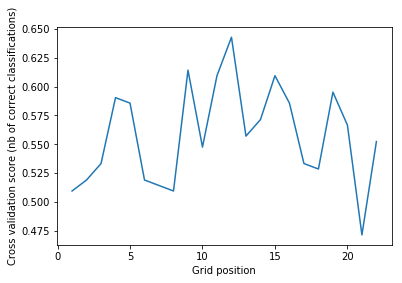

In [484]:
plt.figure()
plt.xlabel("Grid position")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [485]:
X_test_selected = X_test.loc[:, var_selected_features]
X_train_selected = X_train.loc[:, var_selected_features]

In [457]:
# training score
y_train_pred, score = test_model(X_train_selected, y_train, selector)

In [458]:
score

1.0

In [459]:
y_pred, score = test_model(X_test_selected, y_test, selector)

In [460]:
score

0.5714285714285714

In [461]:
selected_columns

Index(['ENSG00000001461', 'ENSG00000001497', 'ENSG00000001561',
       'ENSG00000001617', 'ENSG00000001626', 'ENSG00000001629',
       'ENSG00000001630', 'ENSG00000001631', 'ENSG00000002016',
       'ENSG00000002079',
       ...
       'ENSG00000283632', 'ENSG00000283633', 'ENSG00000283636',
       'ENSG00000283644', 'ENSG00000283646', 'ENSG00000283652',
       'ENSG00000283667', 'ENSG00000283674', 'ENSG00000283689',
       'ENSG00000283696'],
      dtype='object', length=13676)

In [462]:
rf_features = selected_columns

## Linear SVM

In [499]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [500]:
# SVM
selector, selected_columns, var_selected_features = feature_selection(X_train, y_train, LinearSVC(C=0.1, max_iter=10000, random_state=42), step=0.05, n_jobs=32, num_features=10, variance_threshold=0)

/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


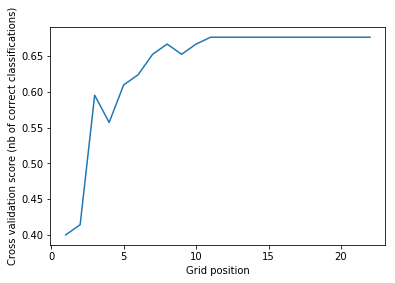

In [501]:
plt.figure()
plt.xlabel("Grid position")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [502]:
scores = []
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    selector.estimator.fit(X.iloc[train_index, :][selected_columns], y[train_index])
    scores.append(selector.estimator.score(X.iloc[test_index, :][selected_columns], y[test_index]))

/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/eerhan/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblin

In [511]:
scores

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [496]:
selected_columns

Index(['ENSG00000000419', 'ENSG00000001167', 'ENSG00000001460',
       'ENSG00000001461', 'ENSG00000001497', 'ENSG00000001617',
       'ENSG00000001626', 'ENSG00000001630', 'ENSG00000001631',
       'ENSG00000002079',
       ...
       'ENSG00000283472', 'ENSG00000283485', 'ENSG00000283526',
       'ENSG00000283553', 'ENSG00000283554', 'ENSG00000283585',
       'ENSG00000283623', 'ENSG00000283633', 'ENSG00000283644',
       'ENSG00000283646'],
      dtype='object', length=12310)

In [466]:
svm_features = selected_columns

In [467]:
X_test_selected = X_test.loc[:, var_selected_features]
X_train_selected = X_train.loc[:, var_selected_features]

In [504]:
# training score
y_train_pred, score = test_model(X_train_selected, y_train, selector)

In [505]:
score

1.0

In [506]:
y_pred, score = test_model(X_test_selected, y_test, selector)

In [507]:
score

0.47619047619047616

## SVM RBF

In [472]:
# K fold cross validations

In [473]:
kf = KFold(n_splits=len(X), random_state=None, shuffle=False)

In [474]:
# Can't do RFE with SVM with RBF because it doesn't have feature importances
svm_rbf = SVC(kernel='rbf', C=1, max_iter=10000, random_state=42, gamma='scale')

In [475]:
scores = []
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    svm_rbf.fit(X.iloc[train_index, :][rf_features], y[train_index])
    scores.append(svm_rbf.score(X.iloc[test_index, :][rf_features], y[test_index]))

TRAIN: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] TEST: [0]
TRAIN: [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] TEST: [1]
TRAIN: [  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36

In [476]:
svm_rbf.score(X_test.loc[:, rf_features], y_test)

0.0

In [477]:
X_test_selected = X_test.loc[:, var_selected_features]
X_train_selected = X_train.loc[:, var_selected_features]

In [478]:
# training score
y_train_pred, score = test_model(X_train_selected, y_train, selector)

In [479]:
score

1.0

In [480]:
y_pred, score = test_model(X_test_selected, y_test, selector)

In [481]:
score

0.47619047619047616

## feature importances

In [ ]:
selector.estimator.fit(X_train_selected, y_train)

In [210]:
selector.estimator.score(X_test_selected, y_test)

-0.14858053804973892

In [177]:
pd.DataFrame({'feature_importances': selector.estimator.feature_importances_,
              'feature_name': X_test_selected.columns.values}).sort_values('feature_importances', ascending=False)

,feature_importances,feature_name
2404,0.016212,ENSG00000102081
11813,0.015382,ENSG00000174871
12179,0.014988,ENSG00000177674
18455,0.014194,ENSG00000258839
15700,0.013200,ENSG00000224531
7644,0.012658,ENSG00000144455
14596,0.010587,ENSG00000203778
20563,0.010163,ENSG00000278765
7259,0.010086,ENSG00000141510
14202,0.009834,ENSG00000197894
